In [85]:
import h5py
import PIL.Image as I
import numpy as np
import matplotlib.pyplot as plt
import sys

#tarea modelado


def load_and_train( opts ):
    def nll( g, Y ):
        return -(Y * np.log(g) + (1 - Y) * np.log( 1-g ) ).flatten().sum()
    def sd( a ):
        return 1/(1 + np.exp(-a))
    def add1dims(X):
        return np.hstack( (X, np.ones((X.shape[0], 1)) ))
    def predict(X, w, add_dims=True):
        if add_dims: X = add1dims(X)
        return sd( X@w )

    
    trainX = trainY = None
    classes = None
    with h5py.File(opts['h5_file_path'], 'r') as f:
        trainX = f['train_set_x'][:]
        trainY = f['train_set_y'][:]
        classes = f['list_classes'][:].astype(str)
    
        
        X = trainX.reshape( [209, 64*64*3] ).astype(float) / 255
        Y = trainY[:, None].astype(float)

    X = add1dims(X)
    w = np.random.randn( X.shape[1], 1 )
    K = 1
    if opts['normalize_grad']:
        K = X.shape[0]

    losses = []
    _lda = opts['pred_bound']
    lr = opts['lr']
    for i in range(opts['epochs']):
        g = predict(X, w, add_dims=False)
        g = np.clip(g, _lda, 1-_lda)
        #print(g.shape)
        #print(X.T.shape, np.diag( g * (g- 1) ).shape, X.shape)
        gradW = X.T@(Y - g)
        w = w + lr/K * gradW
        loss = nll(g, Y)
        losses.append(loss)
        if i > 1 and abs( (losses[i]-losses[i-1])/losses[i] ) < opts['eps']:
            break
        if opts['verbose']:
            sys.stdout.write(f"\rEpoch { i+1 }/{ opts['epochs'] }, Last Error: {losses[i]:.2f}")
            
    def class_predict( X, w, add_dims=True ):
        if len(X.shape) > 2:
            X = X.reshape( [-1, 64 * 64 * 3] )
        return (predict( X, w, add_dims ) > .5).astype(int)

    def image_predict( path, w ):
        img =  np.array(I.open(path).resize([64, 64])).astype(float)[ None, :, :, : ]
        if np.max(img) > 1:
            img = img / 255
        return class_predict( img, w, add_dims=True ).flatten()

    accuracy = np.sum(class_predict( X, w, False ) == Y)/X.shape[0]
    return w, losses, class_predict, predict, image_predict, accuracy
    

    
        


Epoch 1500/1500, Last Error: 162.08

Text(0.5, 1.0, '82% Correctos')

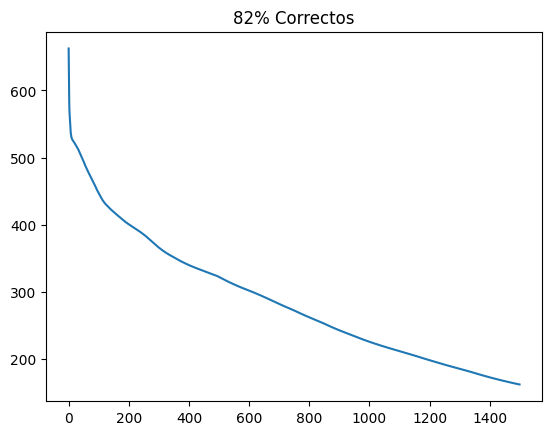

In [82]:
opts = {
    'h5_file_path': r'C:\Users\jb\Downloads\gatillos_train.h5',
    'normalize_grad': True, 
    'eps': 1e-7,
    'pred_bound': 0.001,
    'epochs': 1500,
    'verbose': True,
    'lr': 0.01
}
# 1 Gato
# 0 No Gato

w, losses, class_predict, predict, image_predict,  accuracy = load_and_train( opts )
plt.plot(losses)
plt.title(F'{accuracy*100:.0f}% Correctos')

In [84]:
image_predict(r'C:\Users\jb\Downloads\goku_yardrat.jpg', w)

array([0])